Problem:
Given airsheds modelled using HYSPLIT for different input locations in a study region, how can we overlay them directly over one another to create a "mean" airshed for the entire study region?

In [152]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import pyproj as proj
from scipy.optimize import curve_fit
from scipy import interpolate

In [194]:
# Read one file, look at it

df = pd.read_csv('data/tfreq0001_new.csv')
df.head()

,Unnamed: 0,year,month,day,hour,latitude,longitude,frequency
0,0,2010,12,29,0,26.0,-74.9,0.069
1,1,2010,12,29,0,26.2,-75.0,0.069
2,2,2010,12,29,0,26.2,-68.5,0.069
3,3,2010,12,29,0,26.4,-68.6,0.069
4,4,2010,12,29,0,26.5,-75.0,0.069


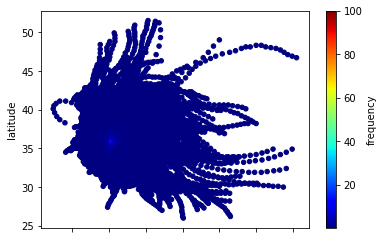

In [197]:
# Plot to get an idea of dispersion

df.plot.scatter(x='longitude',y='latitude',c='frequency',colormap='jet')

In [195]:
# Find the center (could read this from a table, too)

print(df[df.frequency==100])
center_lat, center_lon = df[df.frequency==100]['latitude'].values[0], df[df.frequency==100]['longitude'].values[0]

      Unnamed: 0  year  month  day  hour  latitude  longitude  frequency
5482        5482  2010     12   29     0      36.3      -84.7      100.0


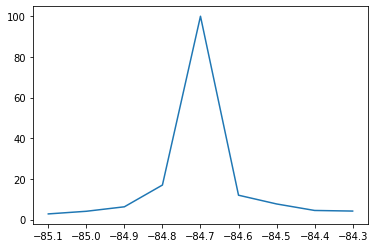

In [196]:
# What's the east/west dispersion?

tol = .5 # How many degrees out to look
idx = (df.latitude==center_lat) & (np.abs(df.longitude-center_lon) < tol)
plt.plot(df.loc[idx]['longitude'],df.loc[idx]['frequency'])

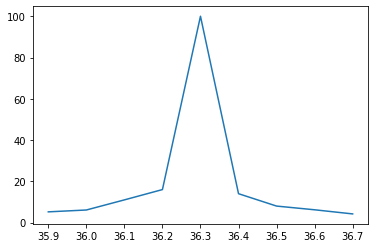

In [15]:
# What's the north/south dispersion?
tol = .5
idx = (df.longitude==center_lon) & (np.abs(df.latitude-center_lat) < tol)
plt.plot(df.loc[idx]['latitude'],df.loc[idx]['frequency'])

## Aggregation

In [153]:
tol = 1 # in degrees.  How far out to include.

out_df = pd.DataFrame()

fns = glob.glob('data/*_new.csv')
for i,fn in enumerate(fns):
    df = pd.read_csv(fn)
    # Find the center
    center_lat, center_lon = df[df.frequency==100]['latitude'].values[0], df[df.frequency==100]['longitude'].values[0]

    # Project to azimuthal equidistant centered on center_lat, center_lon
    p1 = proj.Proj(init='epsg:4326')
    p2 = proj.Proj(proj="aeqd", lat_0=center_lat, lon_0=center_lon, datum="WGS84", units="m")
    df['x'], df['y'] = proj.transform(p1,p2,df.longitude.values,df.latitude.values)  
    
    # alternatively, define x and y as degrees off of center lat/lon
    df['x_deg'] = df['longitude'] - center_lon
    df['y_deg'] = df['latitude'] - center_lat
    
    df['i'] = i
    
    out_df = out_df.append(df.loc[:,['i','x','y','x_deg','y_deg','frequency']],ignore_index=True)

# Calculate distance, useful for later filtering
out_df['d'] = (out_df.x**2 + out_df.y**2)**.5
    
# Apply a threshold before saving?
# out_df = out_df.loc[out_df.frequency >= 1]
    
out_df.to_csv('output/aggregate_projected_points.csv',index=False)

# Visualizing

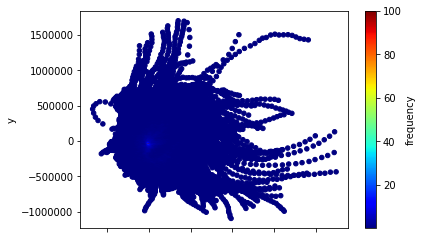

In [198]:
# Each individual plot is recoverable, and has now been projected so metric distances are correct

idx = out_df['i'] == 0
out_df.loc[idx,:].plot.scatter(x='x',y='y',c='frequency',colormap='jet')

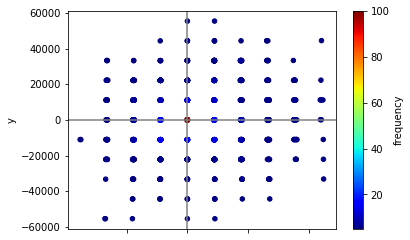

In [101]:
# View the output points, just where frequency is greater than a threshold to see the shape more easily

threshold = 5

idx = out_df['frequency'] > threshold
out_df.loc[idx,:].plot.scatter(x='x',y='y',c='frequency',colormap='jet')
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')

Text(0.5, 1.0, 'latitude')

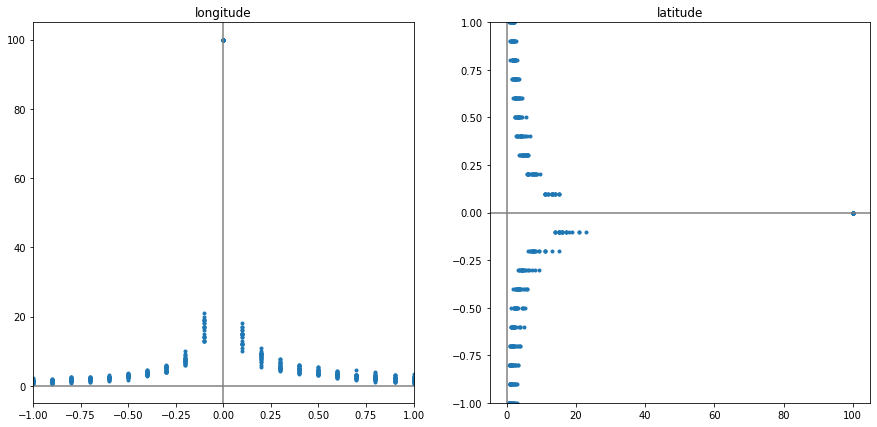

In [108]:
# Plot dispersion by latitude and longitude

plt.figure(figsize=(15,7))

plt.subplot(121)
idx = out_df.y_deg==0
plt.plot(out_df.loc[idx,'x_deg'],out_df.loc[idx,'frequency'],'.')
plt.xlim(-1,1)
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.title('longitude')

plt.subplot(122)
idx = out_df.x_deg==0
plt.plot(out_df.loc[idx,'frequency'],out_df.loc[idx,'y_deg'],'.')
plt.ylim(-1,1)
plt.axhline(0, color='gray')
plt.axvline(0, color='gray')
plt.title('latitude')

# Curve Fitting

The curve_fit function is highly useful for fitting a model of any type.  
The output of this model couuld be used to mathematically generate a 2D kernel for later analysis.

In [157]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

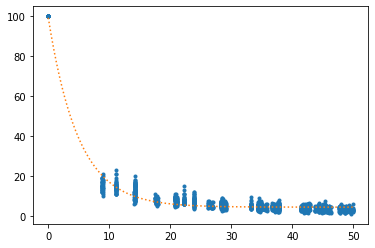

In [164]:
# This is a simple fit for distance, but could be 
idx = out_df.d < 50000

xdata = out_df.loc[idx,'d'] / 1000 # convert to km
ydata = out_df.loc[idx,'frequency']

plt.plot(xdata,ydata,'.')

popt, pcov = curve_fit(func, xdata, ydata)

x = np.linspace(0,np.max(xdata),1000)
y = func(x,popt[0],popt[1],popt[2])
plt.plot(x,y,':')

# Next Steps

Need fits for each individual direction, as well as a selection of model type (decaying exponential? IDW-style distance decay?).  Could also generate an "empirical" model using interpolation, or perhaps best modelled using Kriging in ArcGIS Pro using read-in values from out_df (output/aggregate_projected_points.csv)